<a href="https://colab.research.google.com/github/soyoung9306/3min-keras/blob/master/Simple_yolov2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##FDDB Dataset 다운로드

In [0]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [0]:
!wget "https://drive.google.com/uc?authuser=0&id=1qV4YSzvvTQ7rSi3iS2swkbA56QO-bbs8&export=download" -O fddb.zip

--2019-03-14 04:22:32--  https://drive.google.com/uc?authuser=0&id=1qV4YSzvvTQ7rSi3iS2swkbA56QO-bbs8&export=download
Resolving drive.google.com (drive.google.com)... 209.85.147.138, 209.85.147.101, 209.85.147.113, ...
Connecting to drive.google.com (drive.google.com)|209.85.147.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://drive.google.com/uc?id=1qV4YSzvvTQ7rSi3iS2swkbA56QO-bbs8&export=download [following]
--2019-03-14 04:22:32--  https://drive.google.com/uc?id=1qV4YSzvvTQ7rSi3iS2swkbA56QO-bbs8&export=download
Reusing existing connection to drive.google.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘fddb.zip’

fddb.zip                [ <=>                ]   3.17K  --.-KB/s    in 0s      

2019-03-14 04:23:02 (33.6 MB/s) - ‘fddb.zip’ saved [3244]



In [0]:
!ls

checkpoint  fddb.zip	       retina.ckpt.data-00000-of-00001	sample_data
data	    pretrained_models  retina.ckpt.index		train.graph
eval.graph  resnet.gar.gz      retina.ckpt.meta


In [0]:
!apt-get install unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.


In [0]:
!unzip -q fddb.zip

[fddb.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of fddb.zip or
        fddb.zip.zip, and cannot find fddb.zip.ZIP, period.


In [0]:
!mv face data/FDDB

mv: cannot stat 'face': No such file or directory


In [0]:
!ls data/FDDB

test  train


In [0]:
!ls data/FDDB/train

anchors.json  annotations  classes.json  images


## Data Loader for Detection Model


In [0]:
import os
import numpy as np
import cv2
from cv2 import imread, resize, imwrite
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import glob
import json

In [0]:
IM_EXTENSIONS = ['png', 'jpg', 'bmp']

def load_json(json_path):
    """
    Load json file
    """
    with open(json_path, 'r') as f:
        data = json.load(f)
    return data

def get_best_anchor(anchors, box_wh):
    """
    Select the best anchor with highest IOU
    """
    box_wh = np.array(box_wh)
    best_iou = 0
    best_anchor = 0
    for k, anchor in enumerate(anchors):
        intersect_wh = np.maximum(np.minimum(box_wh, anchor), 0.0)
        intersect_area = intersect_wh[0] * intersect_wh[1]
        box_area = box_wh[0] * box_wh[1]
        anchor_area = anchor[0] * anchor[1]
        iou = intersect_area / (box_area + anchor_area - intersect_area)
        if iou > best_iou:
            best_iou = iou
            best_anchor = k
    return best_anchor

In [0]:
def read_data(data_dir, image_size, pixels_per_grid=32, no_label=False, ratio=1):
    """
    Load the data and preprocessing for YOLO detector
    :param data_dir: str, path to the directory to read. 
                     It should include class_map, anchors, annotations
    :image_size: tuple, image size for resizing images
    :pixels_per_gird: int, the actual size of a grid
    :no_label: bool, whetehr to load labels
    :return: X_set: np.ndarray, shape: (N, H, W, C).
             y_set: np.ndarray, shape: (N, g_H, g_W, anchors, 5 + num_classes).
    """
    im_dir = os.path.join(data_dir, 'images')
    class_map_path = os.path.join(data_dir, 'classes.json')
    anchors_path = os.path.join(data_dir, 'anchors.json')
    class_map = load_json(class_map_path)
    anchors = load_json(anchors_path)
    num_classes = len(class_map)
    grid_h, grid_w = [image_size[i] // pixels_per_grid for i in range(2)]
    im_paths = []
    for ext in IM_EXTENSIONS:
        im_paths.extend(glob.glob(os.path.join(im_dir, '*.{}'.format(ext))))
    if ratio != 1:
      num_img = int(len(im_paths)*ratio)
      im_paths = im_paths[:num_img]
    anno_dir = os.path.join(data_dir, 'annotations')
    images = []
    labels = []

    for im_path in im_paths:
        # load image and resize image
        im = imread(im_path)
        im = np.array(im, dtype=np.float32)
        im_origina_sizes = im.shape[:2]
        im = resize(im, (image_size[1], image_size[0]))
        if len(im.shape) == 2:
            im = np.expand_dims(im, 2)
            im = np.concatenate([im, im, im], -1)
        images.append(im)

        if no_label:
            labels.append(0)
            continue
        # load bboxes and reshape for yolo model
        name = os.path.splitext(os.path.basename(im_path))[0]
        anno_path = os.path.join(anno_dir, '{}.anno'.format(name))
        anno = load_json(anno_path)
        label = np.zeros((grid_h, grid_w, len(anchors), 5 + num_classes))
        for c_idx, c_name in class_map.items():
            if c_name not in anno:
                continue
            for x_min, y_min, x_max, y_max in anno[c_name]:
                oh, ow = im_origina_sizes
                # normalize object coordinates and clip the values
                x_min, y_min, x_max, y_max = x_min / ow, y_min / oh, x_max / ow, y_max / oh
                x_min, y_min, x_max, y_max = np.clip([x_min, y_min, x_max, y_max], 0, 1)
                # assign the values to the best anchor
                anchor_boxes = np.array(anchors) / np.array([ow, oh])
                best_anchor = get_best_anchor(
                    anchor_boxes, [x_max - x_min, y_max - y_min])
                cx = int(np.floor(0.5 * (x_min + x_max) * grid_w))
                cy = int(np.floor(0.5 * (y_min + y_max) * grid_h))
                label[cy, cx, best_anchor, 0:4] = [x_min, y_min, x_max, y_max]
                label[cy, cx, best_anchor, 4] = 1.0
                label[cy, cx, best_anchor, 5 + int(c_idx)] = 1.0
        labels.append(label)

    X_set = np.array(images, dtype=np.float32)
    y_set = np.array(labels, dtype=np.float32)

    return X_set, y_set

In [0]:
class DataSet(object):

    def __init__(self, images, labels=None):
        """
        Construct a new DataSet object.
        :param images: np.ndarray, shape: (N, H, W, C)
        :param labels: np.ndarray, shape: (N, g_H, g_W, anchors, 5 + num_classes).
        """
        if labels is not None:
            assert images.shape[0] == labels.shape[0],\
                ('Number of examples mismatch, between images and labels')
        self._num_examples = images.shape[0]
        self._images = images
        self._labels = labels  # NOTE: this can be None, if not given.
        # image/label indices(can be permuted)
        self._indices = np.arange(self._num_examples, dtype=np.uint)
        self._reset()

    def _reset(self):
        """Reset some variables."""
        self._epochs_completed = 0
        self._index_in_epoch = 0

    @property
    def images(self):
        return self._images

    @property
    def labels(self):
        return self._labels

    @property
    def num_examples(self):
        return self._num_examples

    def sample_batch(self, batch_size, shuffle=True):
        """
        Return sample examples from this dataset.
        :param batch_size: int, size of a sample batch.
        :param shuffle: bool, whether to shuffle the whole set while sampling a batch.
        :return: batch_images: np.ndarray, shape: (N, H, W, C)
                 batch_labels: np.ndarray, shape: (N, g_H, g_W, anchors, 5 + num_classes)
        """

        if shuffle:
            indices = np.random.choice(self._num_examples, batch_size)
        else:
            indices = np.arange(batch_size)
        batch_images = self._images[indices]
        if self._labels is not None:
            batch_labels = self._labels[indices]
        else:
            batch_labels = None
        return batch_images, batch_labels

    def next_batch(self, batch_size, shuffle=True):
        """
        Return the next 'batch_size' examples from this dataset.
        :param batch_size: int, size of a single batch.
        :param shuffle: bool, whether to shuffle the whole set while sampling a batch.
        :return: batch_images: np.ndarray, shape: (N, H, W, C)
                 batch_labels: np.ndarray, shape: (N, g_H, g_W, anchors, 5 + num_classes)
        """

        start_index = self._index_in_epoch

        # Shuffle the dataset, for the first epoch
        if self._epochs_completed == 0 and start_index == 0 and shuffle:
            np.random.shuffle(self._indices)

        # Go to the next epoch, if current index goes beyond the total number
        # of examples
        if start_index + batch_size > self._num_examples:
            # Increment the number of epochs completed
            self._epochs_completed += 1
            # Get the rest examples in this epoch
            rest_num_examples = self._num_examples - start_index
            indices_rest_part = self._indices[start_index:self._num_examples]

            # Shuffle the dataset, after finishing a single epoch
            if shuffle:
                np.random.shuffle(self._indices)

            # Start the next epoch
            start_index = 0
            self._index_in_epoch = batch_size - rest_num_examples
            end_index = self._index_in_epoch
            indices_new_part = self._indices[start_index:end_index]

            images_rest_part = self._images[indices_rest_part]
            images_new_part = self._images[indices_new_part]
            batch_images = np.concatenate(
                (images_rest_part, images_new_part), axis=0)
            if self._labels is not None:
                labels_rest_part = self._labels[indices_rest_part]
                labels_new_part = self._labels[indices_new_part]
                batch_labels = np.concatenate(
                    (labels_rest_part, labels_new_part), axis=0)
            else:
                batch_labels = None
        else:
            self._index_in_epoch += batch_size
            end_index = self._index_in_epoch
            indices = self._indices[start_index:end_index]
            batch_images = self._images[indices]
            if self._labels is not None:
                batch_labels = self._labels[indices]
            else:
                batch_labels = None

        return batch_images, batch_labels

In [0]:
# set paths
root_dir = os.path.join('data/FDDB/') #FIXME
trainval_dir = os.path.join(root_dir, 'train')
test_dir = os.path.join(root_dir, 'test')
anchors = load_json(os.path.join(trainval_dir, 'anchors.json'))
class_map = load_json(os.path.join(trainval_dir, 'classes.json'))

# set hyperparameters for data
IM_SIZE = (416, 416)
NUM_CLASSES = 1
VALID_RATIO = 0.1

In [0]:
X_trainval, y_trainval = read_data(trainval_dir, IM_SIZE, ratio=0.5)
trainval_size = X_trainval.shape[0]
val_size = int(trainval_size * VALID_RATIO)
val_set = DataSet(X_trainval[:val_size], y_trainval[:val_size])
train_set = DataSet(X_trainval[val_size:], y_trainval[val_size:])

In [0]:
X_test, y_test = read_data(test_dir, IM_SIZE)
test_set = DataSet(X_test, y_test)

## Construct Network

In [0]:
import tensorflow as tf

In [0]:
device_name = tf.test.gpu_device_name()
print('Device name: {}'.format(device_name))

assert device_name == '/device:GPU:0'

Device name: /device:GPU:0


In [0]:
def conv_layer(x, filters, kernel_size, strides, padding='SAME', use_bias=True, **kwargs):
    weights_stddev = kwargs.pop('weights_stddev', 0.01)
    return tf.layers.conv2d(
        x,            
        filters,
        kernel_size, 
        strides, 
        padding, 
        kernel_initializer=tf.random_normal_initializer(stddev=weights_stddev), 
        use_bias=use_bias
    )

def batchNormalization(x, is_train):
    """
    Add a new batchNormalization layer.
    :param x: tf.Tensor, shape: (N, H, W, C) or (N, D)
    :param is_train: tf.placeholder(bool), if True, train mode, else, test mode
    :return: tf.Tensor.
    """
    return tf.layers.batch_normalization(
        x, 
        training=is_train, 
        momentum=0.99, 
        epsilon=0.001, 
        center=True, 
        scale=True
    )

def conv_bn_relu(x, filters, kernel_size, is_train, strides=(1, 1), padding='SAME', relu=True):
    """
    Add conv + bn + Relu layers.
    see conv_layer and batchNormalization function
    """
    conv = conv_layer(x, filters, kernel_size, strides, padding, use_bias=False)
    bn = batchNormalization(conv, is_train)
    if relu:
        return tf.nn.leaky_relu(bn, alpha=0.1)
    else:
        return bn

def max_pool(x, side_l, stride, padding='SAME'):
    """
    Performs max pooling on given input.
    :param x: tf.Tensor, shape: (N, H, W, C).
    :param side_l: int, the side length of the pooling window for each dimension.
    :param stride: int, the stride of the sliding window for each dimension.
    :param padding: str, either 'SAME' or 'VALID',
                         the type of padding algorithm to use.
    :return: tf.Tensor.
    """
    return tf.nn.max_pool(x, ksize=[1, side_l, side_l, 1],
                          strides=[1, stride, stride, 1], padding=padding)

In [0]:
input_shape = list(IM_SIZE) + [3]
num_classes = NUM_CLASSES
grid_size = [x // 32 for x in input_shape[:2]]
num_anchors = len(anchors)

# Prepare Input
X = tf.placeholder(tf.float32, [None] + input_shape)
y = tf.placeholder(tf.float32, [None] + grid_size + [num_anchors] + [5 + num_classes])
is_train = tf.placeholder(tf.bool)

In [0]:
# init build graph
graph = tf.get_default_graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [0]:
d = dict()

#conv1 - batch_norm1 - leaky_relu1 - pool1
with tf.variable_scope('layer1'):
    d['conv1'] = conv_bn_relu(X, 32, (3, 3), is_train)
    d['pool1'] = max_pool(d['conv1'], 2, 2, padding='SAME')
# (416, 416, 3) --> (208, 208, 32)

#conv2 - batch_norm2 - leaky_relu2 - pool2
with tf.variable_scope('layer2'):
    d['conv2'] = conv_bn_relu(d['pool1'], 64, (3, 3), is_train)
    d['pool2'] = max_pool(d['conv2'], 2, 2, padding='SAME')
# (208, 208, 32) --> (104, 104, 64)

#conv3 - batch_norm3 - leaky_relu3
with tf.variable_scope('layer3'):
    d['conv3'] = conv_bn_relu(d['pool2'], 128, (3, 3), is_train)
# (104, 104, 64) --> (104, 104, 128)

#conv4 - batch_norm4 - leaky_relu4
with tf.variable_scope('layer4'):
    d['conv4'] = conv_bn_relu(d['conv3'], 64, (1, 1), is_train)
# (104, 104, 128) --> (104, 104, 64)

#conv5 - batch_norm5 - leaky_relu5 - pool5
with tf.variable_scope('layer5'):
    d['conv5'] = conv_bn_relu(d['conv4'], 128, (3, 3), is_train)
    d['pool5'] = max_pool(d['conv5'], 2, 2, padding='SAME')
# (104, 104, 64) --> (52, 52, 128)

#conv6 - batch_norm6 - leaky_relu6
with tf.variable_scope('layer6'):
    d['conv6'] = conv_bn_relu(d['pool5'], 256, (3, 3), is_train)
# (52, 52, 128) --> (52, 52, 256)

#conv7 - batch_norm7 - leaky_relu7
with tf.variable_scope('layer7'):
    d['conv7'] = conv_bn_relu(d['conv6'], 128, (1, 1), is_train)
# (52, 52, 256) --> (52, 52, 128)

#conv8 - batch_norm8 - leaky_relu8 - pool8
with tf.variable_scope('layer8'):
    d['conv8'] = conv_bn_relu(d['conv7'], 256, (3, 3), is_train)
    d['pool8'] = max_pool(d['conv8'], 2, 2, padding='SAME')
# (52, 52, 128) --> (26, 26, 256)

#conv9 - batch_norm9 - leaky_relu9
with tf.variable_scope('layer9'):
    d['conv9'] = conv_bn_relu(d['pool8'], 512, (3, 3), is_train)
# (26, 26, 256) --> (26, 26, 512)

#conv10 - batch_norm10 - leaky_relu10
with tf.variable_scope('layer10'):
    d['conv10'] = conv_bn_relu(d['conv9'], 256, (1, 1), is_train)
# (26, 26, 512) --> (26, 26, 256)

#conv11 - batch_norm11 - leaky_relu11
with tf.variable_scope('layer11'):
    d['conv11'] = conv_bn_relu(d['conv10'], 512, (3, 3), is_train)
# (26, 26, 256) --> (26, 26, 512)

#conv12 - batch_norm12 - leaky_relu12
with tf.variable_scope('layer12'):
    d['conv12'] = conv_bn_relu(d['conv11'], 256, (1, 1), is_train)
# (26, 26, 512) --> (26, 26, 256)

#conv13 - batch_norm13 - leaky_relu13 - pool13
with tf.variable_scope('layer13'):
    d['conv13'] = conv_bn_relu(d['conv12'], 512, (3, 3), is_train)
    d['pool13'] = max_pool(d['conv13'], 2, 2, padding='SAME')
# (26, 26, 256) --> (13, 13, 512)

#conv14 - batch_norm14 - leaky_relu14
with tf.variable_scope('layer14'):
    d['conv14'] = conv_bn_relu(d['pool13'], 1024, (3, 3), is_train)
# (13, 13, 512) --> (13, 13, 1024)

#conv15 - batch_norm15 - leaky_relu15
with tf.variable_scope('layer15'):
    d['conv15'] = conv_bn_relu(d['conv14'], 512, (1, 1), is_train)
# (13, 13, 1024) --> (13, 13, 512)

#conv16 - batch_norm16 - leaky_relu16
with tf.variable_scope('layer16'):
    d['conv16'] = conv_bn_relu(d['conv15'], 1024, (3, 3), is_train)
# (13, 13, 512) --> (13, 13, 1024)

#conv17 - batch_norm16 - leaky_relu17
with tf.variable_scope('layer17'):
    d['conv17'] = conv_bn_relu(d['conv16'], 512, (1, 1), is_train)
# (13, 13, 1024) --> (13, 13, 512)

#conv18 - batch_norm18 - leaky_relu18
with tf.variable_scope('layer18'):
    d['conv18'] = conv_bn_relu(d['conv17'], 1024, (3, 3), is_train)
# (13, 13, 512) --> (13, 13, 1024)

#conv19 - batch_norm19 - leaky_relu19
with tf.variable_scope('layer19'):
    d['conv19'] = conv_bn_relu(d['conv18'], 1024, (3, 3), is_train)
# (13, 13, 1024) --> (13, 13, 1024)

#Detection Layer
#conv20 - batch_norm20 - leaky_relu20
with tf.variable_scope('layer20'):
    d['conv20'] = conv_bn_relu(d['conv19'], 1024, (3, 3), is_train)
# (13, 13, 1024) --> (13, 13, 1024)

# concatenate layer20 and layer 13 using space to depth
with tf.variable_scope('layer21'):
    d['skip_connection'] = conv_bn_relu(d['conv13'], 64, (1, 1), is_train)
    d['skip_space_to_depth_x2'] = tf.space_to_depth(
        d['skip_connection'], block_size=2)
    d['conv21'] = conv_bn_relu(d['conv20'], 1024, (3, 3), is_train)
    d['concat21'] = tf.concat(
        [d['skip_space_to_depth_x2'], d['conv21']], axis=-1)
# (13, 13, 1024) --> (13, 13, 256+1024)

#conv22 - batch_norm22 - leaky_relu22
with tf.variable_scope('layer22'):
    d['conv22'] = conv_bn_relu(d['concat21'], 1024, (3, 3), is_train)
# (13, 13, 1280) --> (13, 13, 1024)

with tf.variable_scope('output_layer'):
    output_channel = num_anchors * (5 + num_classes)
    d['logits'] = conv_layer(d['conv22'], output_channel, (1, 1), (1, 1),
                            padding='SAME', use_bias=True)
    d['pred'] = tf.reshape(
        d['logits'], (-1, grid_size[0], grid_size[1], num_anchors, 5 + num_classes))
# (13, 13, 1024) --> (13, 13, num_anchors , (5 + num_classes))

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.batch_normalization instead.


In [0]:
logits = d['logits']
pred = d['pred']

## Build Loss

In [0]:
loss_weights = [5, 5, 5, 0.5, 1.0] #xy, wh, conf, no_conf, class_probs 

grid_h, grid_w = grid_size
grid_wh = np.reshape([grid_w, grid_h], [1, 1, 1, 1, 2]).astype(np.float32)
cxcy = np.transpose([np.tile(np.arange(grid_w), grid_h), 
                     np.repeat(np.arange(grid_h), grid_h)])
cxcy = np.reshape(cxcy, (1, grid_h, grid_w, 1, 2))

txty, twth = pred[..., 0:2], pred[..., 2:4]
confidence = tf.sigmoid(pred[..., 4:5])
class_probs = tf.nn.softmax(pred[..., 5:], axis=-1)\
            if num_classes > 1 else tf.sigmoid(pred[..., 5:])
bxby = tf.sigmoid(txty) + cxcy
pwph = np.reshape(anchors, (1, 1, 1, num_anchors, 2)) / 32
bwbh = tf.exp(twth) * pwph

# calculating for prediction
nxny, nwnh = bxby / grid_wh, bwbh / grid_wh
nx1ny1, nx2ny2 = nxny - 0.5 * nwnh, nxny + 0.5 * nwnh
pred_y = tf.concat((nx1ny1, nx2ny2, confidence, class_probs), axis=-1)

# calculating IoU for metric
num_objects = tf.reduce_sum(y[..., 4:5], axis=[1, 2, 3, 4])
max_nx1ny1 = tf.maximum(y[..., 0:2], nx1ny1)
min_nx2ny2 = tf.minimum(y[..., 2:4], nx2ny2)
intersect_wh = tf.maximum(min_nx2ny2 - max_nx1ny1, 0.0)
intersect_area = tf.reduce_prod(intersect_wh, axis=-1)
intersect_area = tf.where(
    tf.equal(intersect_area, 0.0), tf.zeros_like(intersect_area), intersect_area)
gt_box_area = tf.reduce_prod(y[..., 2:4] - y[..., 0:2], axis=-1)
box_area = tf.reduce_prod(nx2ny2 - nx1ny1, axis=-1)
iou = tf.truediv(intersect_area, (gt_box_area + box_area - intersect_area))

gt_bxby = 0.5 * (y[..., 0:2] + y[..., 2:4]) * grid_wh
gt_bwbh = (y[..., 2:4] - y[..., 0:2]) * grid_wh

resp_mask = y[..., 4:5]
no_resp_mask = 1.0 - resp_mask
#gt_confidence = resp_mask * tf.expand_dims(iou, axis=-1)
gt_confidence = resp_mask
gt_class_probs = y[..., 5:]

loss_bxby = loss_weights[0] * resp_mask * tf.square(gt_bxby - bxby)
loss_bwbh = loss_weights[1] * resp_mask * tf.square(tf.sqrt(gt_bwbh) - tf.sqrt(bwbh))
loss_resp_conf = loss_weights[2] * resp_mask * tf.square(gt_confidence - confidence)
loss_no_resp_conf = loss_weights[3] * no_resp_mask * tf.square(gt_confidence - confidence)
loss_class_probs = loss_weights[4] * resp_mask * tf.square(gt_class_probs - class_probs)

merged_loss = tf.concat((
                        loss_bxby,
                        loss_bwbh,
                        loss_resp_conf,
                        loss_no_resp_conf,
                        loss_class_probs
                        ),
                        axis=-1)
total_loss = tf.reduce_sum(merged_loss, axis=-1)
total_loss = tf.reduce_mean(total_loss)

## Training Session

In [0]:
def nms(boxes, conf_thres=0.2, iou_thres=0.5):
    x1 = boxes[..., 0]
    y1 = boxes[..., 1]
    x2 = boxes[..., 2]
    y2 = boxes[..., 3]
    areas = (x2 - x1) * (y2 - y1)
    scores = boxes[..., 4]

    keep = []
    order = scores.argsort()[::-1]

    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1)
        h = np.maximum(0.0, yy2 - yy1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= iou_thres)[0]
        order = order[inds + 1]

    nms_box = []
    for idx in range(len(boxes)):
        if idx in keep and boxes[idx, 4] > conf_thres:
            nms_box.append(boxes[idx])
        else:
            nms_box.append(np.zeros(boxes.shape[-1]))
    boxes = np.array(nms_box)
    return boxes

def convert_boxes(input_y):
    is_batch = len(input_y.shape) == 5
    if not is_batch:
        input_y = np.expand_dims(input_y, 0)
    boxes = np.reshape(input_y, (input_y.shape[0], -1, input_y.shape[-1]))
    if is_batch:
        return np.array(boxes)
    else:
        return boxes[0]

def predict_nms_boxes(input_y, conf_thres=0.2, iou_thres=0.5):
    is_batch = len(input_y.shape) == 5
    if not is_batch:
        input_y = np.expand_dims(input_y, 0)
    boxes = np.reshape(input_y, (input_y.shape[0], -1, input_y.shape[-1]))
    nms_boxes = []
    for box in boxes:
        nms_box = nms(box, conf_thres, iou_thres)
        nms_boxes.append(nms_box)
    if is_batch:
        return np.array(nms_boxes)
    else:
        return nms_boxes[0]

def cal_recall(gt_bboxes, bboxes, iou_thres=0.5):
    p = 0
    tp = 0
    for idx, (gt, bbox) in enumerate(zip(gt_bboxes, bboxes)):
        gt = gt[np.nonzero(np.any(gt > 0, axis=1))]
        bbox = bbox[np.nonzero(np.any(bbox > 0, axis=1))]
        p += len(gt)
        if bbox.size == 0:
            continue
        iou = _cal_overlap(gt, bbox)
        predicted_class = np.argmax(bbox[...,5:], axis=-1)
        for g, area in zip(gt, iou):
            gt_c = np.argmax(g[5:])
            idx = np.argmax(area)
            if np.max(area) > iou_thres and predicted_class[idx] == gt_c:
                tp += 1
    return tp / p

def _cal_overlap(a, b):
    area = (b[:, 2] - b[:, 0]) * (b[:, 3] - b[:, 1])

    iw = np.minimum(np.expand_dims(a[:, 2], axis=1), b[:, 2]) - \
        np.maximum(np.expand_dims(a[:, 0], axis=1), b[:, 0])
    ih = np.minimum(np.expand_dims(a[:, 3], axis=1), b[:, 3]) - \
        np.maximum(np.expand_dims(a[:, 1], axis=1), b[:, 1])

    iw = np.maximum(iw, 0)
    ih = np.maximum(ih, 0)
    intersection = iw * ih

    ua = np.expand_dims((a[:, 2] - a[:, 0]) *
                        (a[:, 3] - a[:, 1]), axis=1) + area - intersection

    ua = np.maximum(ua, np.finfo(float).eps)

    return intersection / ua


In [0]:
def score(y_true, y_pred, **kwargs):
    """Compute Recall for a given predicted bboxes"""
    nms_flag = kwargs.pop('nms_flag', True)
    if nms_flag:
        bboxes = predict_nms_boxes(y_pred)
    else:
        bboxes = convert_boxes(y_pred)
    gt_bboxes = convert_boxes(y_true)
    score = cal_recall(gt_bboxes, bboxes)
    return score

def predict(sess, dataset, **kwargs):
    batch_size = kwargs.pop('batch_size', 16)
    pred_size = dataset.num_examples
    num_steps = pred_size // batch_size
    flag = int(bool(pred_size % batch_size))
    # Start prediction loop
    _y_pred = []
    for i in range(num_steps + flag):
        if i == num_steps and flag:
            _batch_size = pred_size - num_steps * batch_size
        else:
            _batch_size = batch_size
        X_true, _ = dataset.next_batch(_batch_size, shuffle=False)

        # Compute predictions
        y_pred = sess.run(pred_y, feed_dict={
                          X: X_true, is_train: False})

        _y_pred.append(y_pred)
    _y_pred = np.concatenate(_y_pred, axis=0)
    return _y_pred

In [0]:
sess = tf.Session(graph=graph, config=config)
saver = tf.train.Saver()

In [0]:
# Set hyperparameters for training
batch_size = 2
num_epochs = 5
learning_rate = 1e-5
eps = 1e-3
num_eval = 128

In [0]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
update_vars = tf.trainable_variables()
with tf.control_dependencies(extra_update_ops):
    train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).\
                minimize(total_loss, var_list=update_vars)

Instructions for updating:
Use tf.cast instead.


In [0]:
sess.run(tf.global_variables_initializer())

In [0]:
train_size = train_set.num_examples
num_steps_per_epoch = train_size // batch_size
num_steps = num_epochs * num_steps_per_epoch

In [0]:
curr_epoch = 1
best_score = 0
curr_score = 0
# Start training loop
for i in range(num_steps):
    X_true, y_true = train_set.next_batch(batch_size, shuffle=True)
    _, loss, y_pred = sess.run([train_op, total_loss, pred_y],
                              feed_dict={X:X_true, y: y_true, is_train: True})
    if (i+1) % num_eval == 0:
        step_score = score(y_true, y_pred)
        eval_y_pred = predict(sess, val_set)
        eval_score = score(val_set.labels, eval_y_pred)
        print('[epoch {}]\tloss: {:.6f} |Train score: {:.6f} |Eval score: {:.6f}'
      .format(curr_epoch, loss, step_score, eval_score))
        curr_score = eval_score

    if curr_score > best_score + eps:
        best_score = curr_score
        saver.save(sess, './yolov2.ckpt')
        
    if (i+1) % num_steps_per_epoch == 0:
        curr_epoch += 1

[epoch 1]	loss: 0.087635 |Train score: 1.000000 |Eval score: 0.670782
[epoch 1]	loss: 0.058776 |Train score: 0.400000 |Eval score: 0.724280
[epoch 1]	loss: 0.047020 |Train score: 0.714286 |Eval score: 0.711934
[epoch 1]	loss: 0.042550 |Train score: 0.750000 |Eval score: 0.201646
[epoch 2]	loss: 0.024227 |Train score: 0.500000 |Eval score: 0.436214
[epoch 2]	loss: 0.024470 |Train score: 0.800000 |Eval score: 0.534979
[epoch 2]	loss: 0.018939 |Train score: 0.750000 |Eval score: 0.563786
[epoch 2]	loss: 0.012623 |Train score: 1.000000 |Eval score: 0.613169
[epoch 2]	loss: 0.009954 |Train score: 1.000000 |Eval score: 0.629630
[epoch 3]	loss: 0.013793 |Train score: 0.666667 |Eval score: 0.617284
[epoch 3]	loss: 0.015397 |Train score: 0.750000 |Eval score: 0.666667
[epoch 3]	loss: 0.012011 |Train score: 0.750000 |Eval score: 0.637860
[epoch 3]	loss: 0.012439 |Train score: 1.000000 |Eval score: 0.637860
[epoch 4]	loss: 0.004614 |Train score: 1.000000 |Eval score: 0.679012
[epoch 4]	loss: 0.00

## Test image and draw bboxes

In [0]:
COLORS = [(100, 72, 247),
 (232, 237, 157),
 (45, 241, 42),
 (72, 251, 220),
 (115, 61, 201),
 (38, 253, 214),
 (233, 113, 18),
 (201, 141, 151),
 (57, 199, 175),
 (155, 90, 108),
 (130, 223, 66),
 (40, 211, 140)]

def draw_pred_boxes(image, pred_boxes, class_map, text=True, score=False):
    im_h, im_w = image.shape[:2]
    output = image.copy()
    for box in pred_boxes:
        overlay = output.copy()

        class_idx = np.argmax(box[5:])
        color = COLORS[class_idx]
        line_width, alpha = (2, 0.8)
        x_min, x_max = [int(x * im_w) for x in [box[0], box[2]]]
        y_min, y_max = [int(x * im_h) for x in [box[1], box[3]]]
        cv2.rectangle(overlay, (x_min, y_min),
                      (x_max, y_max), color, line_width)
        output = cv2.addWeighted(overlay, alpha, output, 1 - alpha, 0)

        if text:
            p_text = str(round(np.max(box[5:]), 3)) if score else class_map[str(class_idx)]
            y_offset = -6
            text_size = 0.6
            text_line_width = 1
            output = cv2.putText(output, p_text, (x_min + 4, y_min + y_offset),
                                 cv2.FONT_HERSHEY_DUPLEX, text_size, color, text_line_width)
    return output

In [0]:
saver.restore(sess, './yolov2.ckpt')

INFO:tensorflow:Restoring parameters from ./yolov2.ckpt


In [0]:
test_y_pred = predict(sess, test_set)
test_score = score(test_set.labels, test_y_pred)

print('Test performance: {}'.format(test_score))

Test performance: 0.7667560321715817


In [0]:
r_idx = np.random.choice(test_set.num_examples, 1)
test_images = test_set.images[r_idx]
test_pred_y = sess.run(pred_y, feed_dict={X: test_images, is_train: False})

In [0]:
bboxes = predict_nms_boxes(test_pred_y[0], conf_thres=0.5, iou_thres=0.5)
bboxes = bboxes[np.nonzero(np.any(bboxes > 0, axis=1))]
boxed_img = draw_pred_boxes(test_images[0], bboxes, class_map)

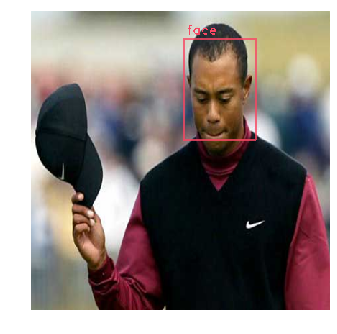

In [0]:
plt.axis("off")
imshow(cv2.cvtColor(boxed_img, cv2.COLOR_BGR2RGB)/255)

In [0]:
sess.close()